In [42]:
import time
import cv2

import numpy as np
from skimage.color import rgb2gray

import matplotlib.pyplot as plt
from IPython import display

In [43]:
plt.rcParams['text.color'] = 'w'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['axes.labelcolor'] = 'w'
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

In [44]:
video_path = 'imgs/traffic.avi'
video_capture = cv2.VideoCapture(video_path)

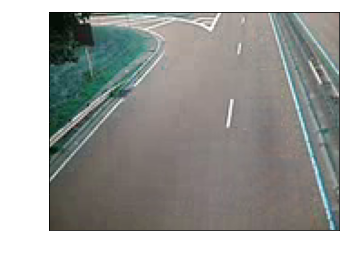

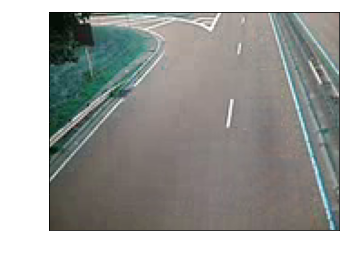

In [45]:
while video_capture.isOpened():
    ret, frame = video_capture.read()
    if not frame is None:
        plt.imshow(frame)
        plt.draw()
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(.01)
    else:
        plt.draw()
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(.01)
        break

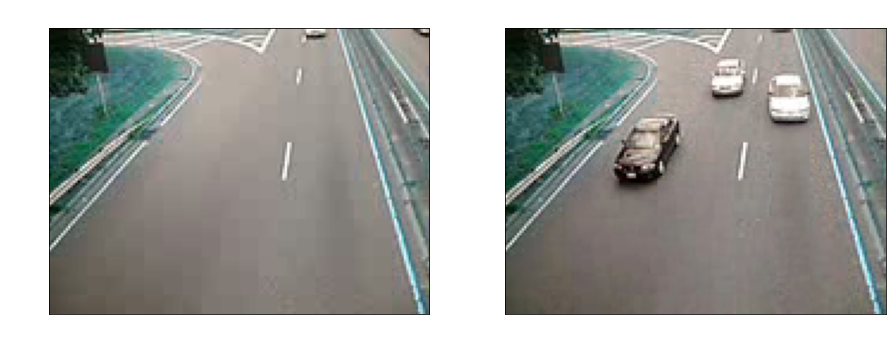

In [46]:
width  = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
height = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
length = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(video_capture.get(cv2.CAP_PROP_FPS))

video_capture.set(cv2.CAP_PROP_POS_FRAMES,0)
_, background_image = video_capture.read()

video_capture.set(cv2.CAP_PROP_POS_FRAMES, 67)
_, image_with_cars = video_capture.read()

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(background_image)
plt.title("background_image")
plt.subplot(122)
plt.title("Image wit cars")
plt.imshow(image_with_cars)

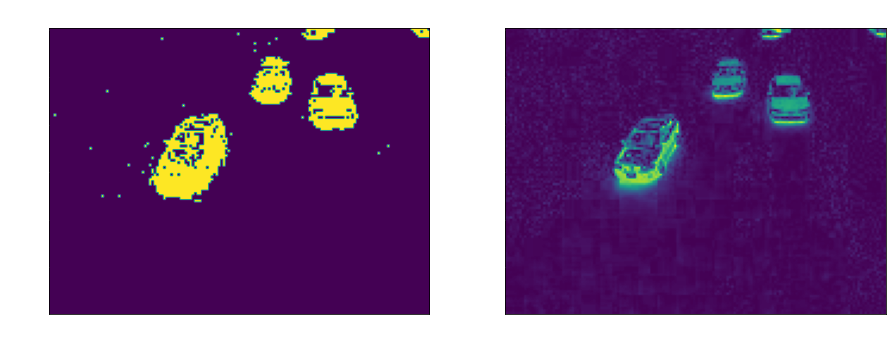

In [47]:
from skimage.measure import label, regionprops, regionprops_table
from skimage import morphology

diff_image = np.abs(rgb2gray(background_image) - rgb2gray(image_with_cars))

diff_thresholded = diff_image*255 > 20

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(diff_thresholded)
plt.title("background_image")
plt.subplot(122)
plt.title("Image wit cars")
plt.imshow(diff_image)

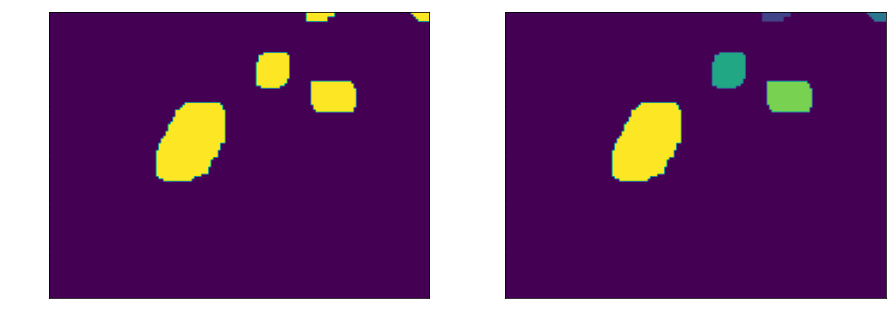

In [48]:
diff_thresholded = morphology.opening(
    morphology.remove_small_holes(diff_thresholded,area_threshold=64),
    selem=morphology.selem.rectangle(8,8))
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(diff_thresholded)

label_img = label(diff_thresholded)
regions = regionprops(label_img)
plt.subplot(122)
plt.imshow(label_img)

<Figure size 1080x720 with 0 Axes>

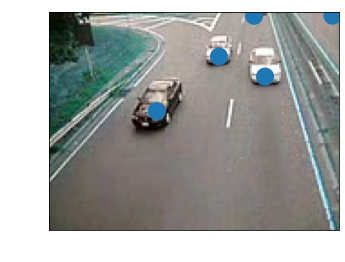

In [49]:
import matplotlib.patches as patches
plt.figure(figsize=(15,10))
fig,ax = plt.subplots(1)
ax.imshow(image_with_cars)

for region in regions:
    centroid_viz =patches.Circle((region.centroid[1], region.centroid[0]))
    ax.add_patch(centroid_viz)

In [50]:
import skimage
from skimage.draw import disk
video_capture = cv2.VideoCapture(video_path)

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('./imgs/tagged_cars.avi',fourcc, fps, (height,width))

while(video_capture.isOpened()):
    ret, frame = video_capture.read()
    if ret==True:
        #1 Detekcia objektov
        diff_image = np.abs(rgb2gray(background_image) - rgb2gray(frame))
        #2 Prahovanie objektov
        diff_thresholded = diff_image*255 > 20
        #3 Morfologicke operacie
        diff_thresholded = morphology.opening(
        morphology.remove_small_holes(diff_thresholded,area_threshold=64),
        selem=morphology.selem.rectangle(8,8))

        label_img = label(diff_thresholded)
        regions = regionprops(label_img)
        #4 Uprava vystupu na zaklade
        for region in regions:
            rr, cc = disk((region.centroid[0], region.centroid[1]), 1)
            frame[rr, cc,:2] = 0
            frame[rr, cc, 2] = 255


        out.write(frame)
    else:
        break

video_capture.release()
out.release()

In [51]:
colors = [(255,0,0), (0,255,0), (0,0,255), (255,255,0)]
color_index = 0
trajectories = []

In [52]:
video_capture = cv2.VideoCapture(video_path)
_, background_image = video_capture.read()

fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('imgs/trajectory_cars.avi',fourcc, fps, (height,width))

while(video_capture.isOpened()):
    ret, frame = video_capture.read()
    if ret == True:

        diff_image = np.abs(rgb2gray(background_image) - rgb2gray(frame))        #skopirovane z predoslej funkcie
        diff_thresholded = diff_image*255 > 20
        diff_thresholded[0:20,:] = 0
        diff_thresholded = morphology.opening(
        morphology.remove_small_holes(diff_thresholded,area_threshold=64),
        selem=morphology.selem.diamond(3))

        label_img = label(diff_thresholded)
        regions = regionprops(label_img)

        centroids = []
        for region in regions:
            centroids.append(region.centroid)

        trajectories_new = []
        for centroid in centroids:
            if len(trajectories) > 0:
                dist = [np.linalg.norm(np.array(trajectory[1][-1][0],trajectory[1][-1][1]) - np.array(centroid[0],centroid[1]))for trajectory in trajectories]
                min_dist = dist[np.argmin(dist)]
                index_min_dist = np.argmin(dist)


                if min_dist < 10:
                    color = trajectories[index_min_dist][0]
                    trajectory = trajectories[index_min_dist][1]
                    trajectory.append(centroid)
                    trajectories_new.append([color,trajectory])
                else:
                    trajectories_new.append([color_index,[centroid]])
                    color_index+=1
                    if color_index > 3 : color_index = 0

            else:
                trajectories_new.append([color_index,[centroid]])
                color_index+=1
                if color_index > 3 : color_index = 0


        trajectories = trajectories_new
        if len(trajectories) > 0 :
            for x in trajectories:
                color = x[0]
                trajectory = x[1]
                for couple in trajectory:
                    row, col = skimage.draw.circle(couple[0],couple[1], 1)
                    frame[row, col, 0] = colors[color][0]
                    frame[row, col, 1] = colors[color][1]
                    frame[row, col, 2] = colors[color][2]
        out.write(frame)
    else:
        break

video_capture.release()
out.release()

<ipython-input-52-e5e1deb16d0e>:55: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19
  row, col = skimage.draw.circle(couple[0],couple[1], 1)
